# Uncertainty-Aware Decision-Making and Planning for Autonomous Forced Merging

In [1]:
import numpy as np
from pytope import Polytope
import matplotlib
import matplotlib.pyplot as plt
import time
import scipy.stats as stats
from scipy.io import loadmat
import os
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec

from Planner_D import Planner_D # DMPC
from Planner_P import Planner_P # Proposed method
from Planner_R import Planner_R # RMPC

from SVModelingHighDDataDistribution import ModelingSV0 # Modeling of SV0
from SVModelingHighDDataDistribution import ModelingSV1 # Modeling of SV1

## Import the distribution data of SVs (offline identified by highD dataset)

In [2]:
xi_HD = loadmat(r'xi_HD.mat')
xi_HD = xi_HD['xi_HD']
xi_HD = xi_HD[0]
len(xi_HD)
cdf_HD = loadmat(r'cdf_HD.mat')
cdf_HD = cdf_HD['cdf_HD']
cdf_HD = cdf_HD[0]

# Basic Parameters

## General Parameters

In [3]:
T  = 0.25     # time interval
N  = 20       # prediction horizon
Np = 10       # prediction horizon in MPC
N_coarse  = 4 # number of reachable set -- coarse
T_coarse  = T*N/N_coarse # time interval for computating the set -- coarse
infinity  = 1000000      # infinity
max_speed = 50  # max speed, m/s
l_veh     = 4.3 # vehicle length
w_veh     = 1.8 # vehicle width
w_lane    = 4   # lane width
DEV       = 5   # dimenstion of EV
DPM       = 6   # diemnsion of vehicle in the point mass
DSV       = 2   # dimenstion of SV
L_Bound   = [0, w_lane, 2*w_lane]
L_Center  = [w_lane/2, 1.5*w_lane]

## Surrouding Vehicle Parameters

In [4]:
A_SV = np.array([[1, T], [0, 1]])
B_SV = np.array([T**2/2, T])
A_SV_coarse = np.array([[1, T_coarse], [0, 1]])
B_SV_coarse = np.array([T_coarse**2/2, T_coarse])
low_bound_state_sv = (-infinity, 0)
up_bound_state_sv  = (infinity, max_speed)
low_bound_ax  = -7
up_bound_ax   =  7
X_SV_Poly = Polytope(lb = low_bound_state_sv, ub = up_bound_state_sv)
U_SV_Poly = Polytope(lb = low_bound_ax, ub = up_bound_ax) # most conservative control set, \mathbb{U}
d_min     = 0.5
d_min_mpc = 0.1


# distribution of SV0
SV0_Min = 0.9
SV0_Max = 1.05
SV0_Min_Index = (np.abs(xi_HD - SV0_Min)).argmin()
SV0_Max_Index = (np.abs(xi_HD - SV0_Max)).argmin()
SV0_Min_Index = cdf_HD[SV0_Min_Index]
SV0_Max_Index = cdf_HD[SV0_Max_Index]

opts_Parameters_SV = {    
    'L_Center': L_Center,
    'N': N,
    'w_lane': w_lane,
    'max_speed': max_speed,
    'DSV': DSV,
    'T': T,
    'xi_HD': xi_HD,
    'cdf_HD': cdf_HD,
    'SV0_Min': SV0_Min_Index,
    'SV0_Max': SV0_Max_Index,
    'SV1_Min': 0,
    'SV1_Max': 1,}

## Ego Vehicle Parameters

In [5]:
N_Lane    = 2
N_M       = 2
K_Lon_EV  = np.array([0.3487, 0.8663])         # long. controller gains of EV
K_Lat_EV  = np.array([0.5681, 1.4003, 1.7260]) # lateral controller gains of EV
SpeedNom  = np.array([30, 30])                 # nominal speed of each lane
Weight    =  np.array([0.1, 0.1, 0.7, 0.1])    # wight for ax ay vx y
H         = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]) # selection matrix for observations from the state
N_Car     = 3
road_terminal   = np.array([1000, L_Center[0]])
terminal_period = 100
terminal_margin = 23
x_min, x_max    = 750, 1500
Poly_road   = Polytope(np.array([[x_min, 1], [x_max, 1], [x_max, 2*w_lane - 1], [x_min, 2*w_lane - 1]]))
A_road      = Poly_road.A # A matrix for driveable area
b_road      = Poly_road.b # b matrix for driveable area

# The r_x and r_y are augmented, for constraining center of EV
tune_1 = 5
tune_2 = 10
x_center, y_center = x_max - tune_2, 1 - tune_1 
r_x, r_y           = x_max - (road_terminal[0] - terminal_period/2), w_lane + tune_1 
p = 4 

opts_Parameters_EV = { 
    'T': T,     
    'N': N,
    'Np': Np,
    'N_coarse': N_coarse,
    'T_coarse': T_coarse,
    'l_veh': l_veh,
    'w_veh': w_veh,
    'w_lane': w_lane,
    'l_f': 1.65,
    'l_r': 1.65,
    'DEV': DEV,
    'DPM': DPM,
    'N_Lane': N_Lane,
    'N_M': N_M,
    'N_Car':N_Car,
    'L_Bound': L_Bound,
    'L_Center': L_Center,
    'K_Lon_EV': K_Lon_EV,
    'K_Lat_EV': K_Lat_EV,
    'SpeedNom': SpeedNom,
    'Weight': Weight,
    'A_SV': A_SV,
    'B_SV': B_SV,
    'A_SV_coarse': A_SV_coarse,
    'B_SV_coarse': B_SV_coarse,
    'X_SV_Poly': X_SV_Poly,
    'U_SV_Poly': U_SV_Poly,
    'infinity': infinity,
    'low_bound_ax': low_bound_ax,
    'up_bound_ax': up_bound_ax,
    'max_speed': max_speed,
    'road_terminal': road_terminal,
    'terminal_margin': terminal_margin,
    'd_min': d_min,
    'd_min_mpc': d_min_mpc,
    'Q1': 100, # steering wheel angle
    'Q2': 0.001, # longitudinal jerk
    'Q3': 1, # lateral error
    'Q4': 1, # long. error
    'A_road': A_road,
    'b_road': b_road,
    'x_c': x_center,
    'y_c': y_center,
    'r_x': r_x,
    'r_y': r_y,
    'p': p,
    'v_low': 0, # lower bound of vel.
    'v_up': max_speed, # up bound of vel.
    'acc_low': -5.0, #-3.43, # lower bound of acc.
    'acc_up': 2.5,#2.27, # up bound of acc.
    'delta_low': -0.1, # lowver bound of front tire angle.
    'delta_up': 0.1, # up bound of front tire angle
}

# Initialization of SV and EV

In [6]:
K_N = 50

x_SV_0_initial = np.array([812.5, 30]) # initial state of SV0: x, v
x_SV_1_initial = np.array([772.5, 30]) # initial state of SV1:x, v
x_EV_0         = np.array([822.5, w_lane/2, 0, 30, 0]) # initial state of EV: x, y phi, v, a

X_SV_State    = list( ) # x and v
Y_SV_State    = list( ) # y
U_SV          = list( ) # a_x
X_SV_Planning = list( ) # SV planning trajectory x and v in the horizon
Y_SV_Planning = list( ) # SV's planning trajectory y in the horizon
X_SV_State.append([x_SV_0_initial, x_SV_1_initial])
Y_SV_State.append([L_Center[1], L_Center[1]])

X_EV_Planning_D   = list( )
X_EV_State_D      = list( )
U_EV_D            = list( )
REFSpeed_EV_D     = list( )
REFSpeed_EV_All_D = list( )
REFLane_EV_D      = list( )
MU_EV_D           = list( )
X_EV_State_D.append(x_EV_0)

X_EV_Planning_P   = list( )
X_EV_State_P      = list( )
U_EV_P            = list( )
REFSpeed_EV_P     = list( )
REFSpeed_EV_All_P = list( )
REFLane_EV_P      = list( )
MU_EV_P           = list( )
X_EV_State_P.append(x_EV_0)

X_EV_Planning_R   = list( )
X_EV_State_R      = list( )
U_EV_R            = list( )
REFSpeed_EV_R     = list( )
REFSpeed_EV_All_R = list( )
REFLane_EV_R      = list( )
MU_EV_R           = list( )
X_EV_State_R.append(x_EV_0)

Robust_SV_D = list( ) # robust obstacle of SV in the prediction horizon
Robust_SV_P = list( ) # robust obstacle of SV in the prediction horizon
Robust_SV_R = list( ) # robust obstacle of SV in the prediction horizon

samples_SV0 = [-0.01, 0.01] # artificial samples
samples_SV1 = [-0.01, 0.01] # artificial samples
samples     = [samples_SV0, samples_SV1]

# Motion Planning

In [7]:
MotionPlanner_D =  Planner_D(Params = opts_Parameters_EV)
MotionPlanner_P =  Planner_P(Params = opts_Parameters_EV)
MotionPlanner_R =  Planner_R(Params = opts_Parameters_EV)
ModelingSV0     = ModelingSV0.ModelingSV0(Params = opts_Parameters_SV)
ModelingSV1     = ModelingSV1.ModelingSV1(Params = opts_Parameters_SV)

start = time.perf_counter( )

for k in range(K_N + 1):
    
    print('the step is', k)
    control_SV0_horizon_k, x_SV0_planning_k, y_SV0_planning_k = ModelingSV0.Return(k, X_SV_State[k][0])
    control_SV1_horizon_k, x_SV1_planning_k, y_SV1_planning_k = ModelingSV1.Return(k, X_SV_State[k][1], X_SV_State[k][0])
    
    control_SV_current_step = [control_SV0_horizon_k[0], control_SV1_horizon_k[0]]
    x_SV_state_next_step    = [x_SV0_planning_k[:, 1], x_SV1_planning_k[:, 1]]
    y_SV_state_next_step    = [y_SV0_planning_k[1],   y_SV1_planning_k[1]]
    x_SV_planning_horizon   = [x_SV0_planning_k, x_SV1_planning_k]
    y_SV_planning_horizon   = [y_SV0_planning_k, y_SV1_planning_k]

    U_k_D, trajectory_planning_k_D, REF_k_D, RefSpeed_k_D, RefLane_k_D, Robust_SV_k_D, mu_k_D     = MotionPlanner_D.Return(0, X_SV_State[k], Y_SV_State[k], X_EV_State_D[k])
    U_k_P, trajectory_planning_k_P, REF_k_P, RefSpeed_k_P, RefLane_k_P, Robust_SV_k_P, mu_k_P  = MotionPlanner_P.Return(X_SV_State[k], Y_SV_State[k], X_EV_State_P[k], samples)
    U_k_R, trajectory_planning_k_R, REF_k_R, RefSpeed_k_R, RefLane_k_R, Robust_SV_k_R, mu_k_R     = MotionPlanner_R.Return(X_SV_State[k], Y_SV_State[k], X_EV_State_R[k])
    
    U_SV.append(control_SV_current_step)
    X_SV_Planning.append(x_SV_planning_horizon)
    Y_SV_Planning.append(y_SV_planning_horizon)
    X_SV_State.append(x_SV_state_next_step)
    Y_SV_State.append(y_SV_state_next_step)
    
    X_EV_Planning_D.append(trajectory_planning_k_D)
    X_EV_State_D.append(trajectory_planning_k_D[:, 1])
    U_EV_D.append(U_k_D)
    REFSpeed_EV_D.append(RefSpeed_k_D)
    REFSpeed_EV_All_D.append(REF_k_D)
    REFLane_EV_D.append(RefLane_k_D)
    Robust_SV_D.append(Robust_SV_k_D)
    MU_EV_D.append(mu_k_D)

    X_EV_Planning_P.append(trajectory_planning_k_P)
    X_EV_State_P.append(trajectory_planning_k_P[:, 1])
    U_EV_P.append(U_k_P)
    REFSpeed_EV_P.append(RefSpeed_k_P)
    REFSpeed_EV_All_P.append(REF_k_P)
    REFLane_EV_P.append(RefLane_k_P)
    Robust_SV_P.append(Robust_SV_k_P)
    MU_EV_P.append(mu_k_P)

    X_EV_Planning_R.append(trajectory_planning_k_R)
    X_EV_State_R.append(trajectory_planning_k_R[:, 1])
    U_EV_R.append(U_k_R)
    REFSpeed_EV_R.append(RefSpeed_k_R)
    REFSpeed_EV_All_R.append(REF_k_R)
    REFLane_EV_R.append(RefLane_k_R)
    Robust_SV_R.append(Robust_SV_k_R)
    MU_EV_R.append(mu_k_R)
    
    samples_SV0 = np.append(samples_SV0, U_SV[k][0])
    samples_SV1 = np.append(samples_SV1, U_SV[k][1])
    samples = [samples_SV0, samples_SV1] # update the sampling
    
end = time.perf_counter( )
total_t = end - start
print ('Average excution time: ', total_t/k)

the step is 0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

the step is 1
the step is 2
the step is 3
the step is 4
the step is 5
the step is 6
the step is 7
the step is 8
the step is 9
the step is 10
the step is 11
the step is 12
the step is 13
the step is 14
the step is 15
the step is 16
the step is 17
the step is 18
the step is 19
the step is 20
the step is 21
the step is 22
the step is 23
the step is 24
the step is 25
the step is 26
the step is 27
the step is 28
the step is 29
the step is 30
the step is 31
the step is 32
the step is 33
the step is 34
the step is 35
the step is 36
the step is 37
the step is 38
the step is 39
the step is 40
the step

# Collect Data 

In [8]:
State_SV0      = np.zeros((3, K_N))
Control_SV0    = np.array([None]*K_N, dtype=float)
State_SV1      = np.zeros((3, K_N))
Control_SV1    = np.array([None]*K_N, dtype=float)
State_EV_D     = np.zeros((DEV, K_N))
State_EV_P     = np.zeros((DEV, K_N))
State_EV_R     = np.zeros((DEV, K_N))
Control_EV_D   = np.zeros((2, K_N))
RefSpeed_EV_D  = np.array([None]*(K_N), dtype=float)
RefLane_EV_D   = np.array([None]*(K_N), dtype=float)
Control_EV_P   = np.zeros((2, K_N))
RefSpeed_EV_P  = np.array([None]*(K_N), dtype=float)
RefLane_EV_P   = np.array([None]*(K_N), dtype=float)
Control_EV_R   = np.zeros((2, K_N))
RefSpeed_EV_R  = np.array([None]*(K_N), dtype=float)
RefLane_EV_R   = np.array([None]*(K_N), dtype=float)

for t in range(K_N):
    State_SV0[0:2, t] = X_SV_State[t][0]
    State_SV0[2, t]   = Y_SV_State[t][0]
    State_SV1[0:2, t] = X_SV_State[t][1]
    State_SV1[2, t]   = Y_SV_State[t][1]
    
    Control_SV0[t] = U_SV[t][0]
    Control_SV1[t] = U_SV[t][1]
    
    State_EV_D[:, t] = X_EV_State_D[t]
    State_EV_P[:, t] = X_EV_State_P[t]
    State_EV_R[:, t] = X_EV_State_R[t]
    
    
    Control_EV_D[:, t] = U_EV_D[t]
    
    Control_EV_P[:, t] = U_EV_P[t]
    
    Control_EV_R[:, t] = U_EV_R[t]
    
    RefSpeed_EV_D[t] = REFSpeed_EV_D[t]
    RefLane_EV_D[t]  = REFLane_EV_D[t]
    
    RefSpeed_EV_P[t] = REFSpeed_EV_P[t]
    RefLane_EV_P[t]  = REFLane_EV_P[t]
    
    RefSpeed_EV_R[t] = REFSpeed_EV_R[t]
    RefLane_EV_R[t]  = REFLane_EV_R[t]
    
t = np.arange(0, T*K_N, T, dtype=float) # total simulation time

# Visualization

## Definie Necessary Functions

In [9]:
def rota_rect(box, theta, x, y):
    box_matrix = np.array(box) - np.repeat(np.array([[x, y]]), len(box), 0)
    theta = -theta
    rota_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    new = box_matrix.dot(rota_matrix) + np.repeat(np.array([[x, y]]), len(box), 0)
    x = [new[0][0], new[1][0], new[2][0], new[3][0], new[0][0]]
    y = [new[0][1], new[1][1], new[2][1], new[3][1], new[0][1]]
    return x, y

def Robust_SV_Vertex(Robust_Obstacle, l_veh, w_veh):
    x_bar = Robust_Obstacle[0]
    y_bar = Robust_Obstacle[1]
    dx = Robust_Obstacle[2] - l_veh/2
    dy = Robust_Obstacle[3] - w_veh/2
    
    xe1 = x_bar - dx
    xe2 = x_bar + dx
    xe3 = x_bar + dx 
    xe4 = x_bar - dx
    
    ye1 = y_bar - dy 
    ye2 = y_bar - dy
    ye3 = y_bar + dy
    ye4 = y_bar + dy
    
    X = [xe1, xe2, xe3, xe4, xe1]    
    Y = [ye1, ye2, ye3, ye4, ye1]
    return X, Y
    
def y_road(x_road, road_terminal_x, road_terminal_period, L_Bound_1, L_Bound_2):
    y_road = list( )
    
    for i in range(len(x_road)):
        if x_road[i] <= road_terminal_x - road_terminal_period/2:
            y_road.append(L_Bound_1)
        elif road_terminal_x - road_terminal_period/2 < x_road[i] < road_terminal_x + road_terminal_period/2:
            y_road.append(None)
        else:
            y_road.append(L_Bound_2)
    
    return np.array(y_road)

color_car = ['b', 'r', 'k'] # color of SV and EV
color_tra = ['b--', 'r--', 'k--']
x_road    = np.linspace(0, x_max, num = x_max)
y_road    =  y_road(x_road, road_terminal[0], terminal_period, L_Bound[0], L_Bound[1])
SpeedNom  = SpeedNom*3.6

theta = np.linspace(-np.pi, np.pi, 400)
x     = x_center + (np.abs(np.cos(theta)))**(2/p) * (r_x - 1) * np.sign(np.cos(theta))
y     = y_center + (np.abs(np.sin(theta)))**(2/p) * (r_y - 1) * np.sign(np.sin(theta))

## Animation for Deterministic Approach

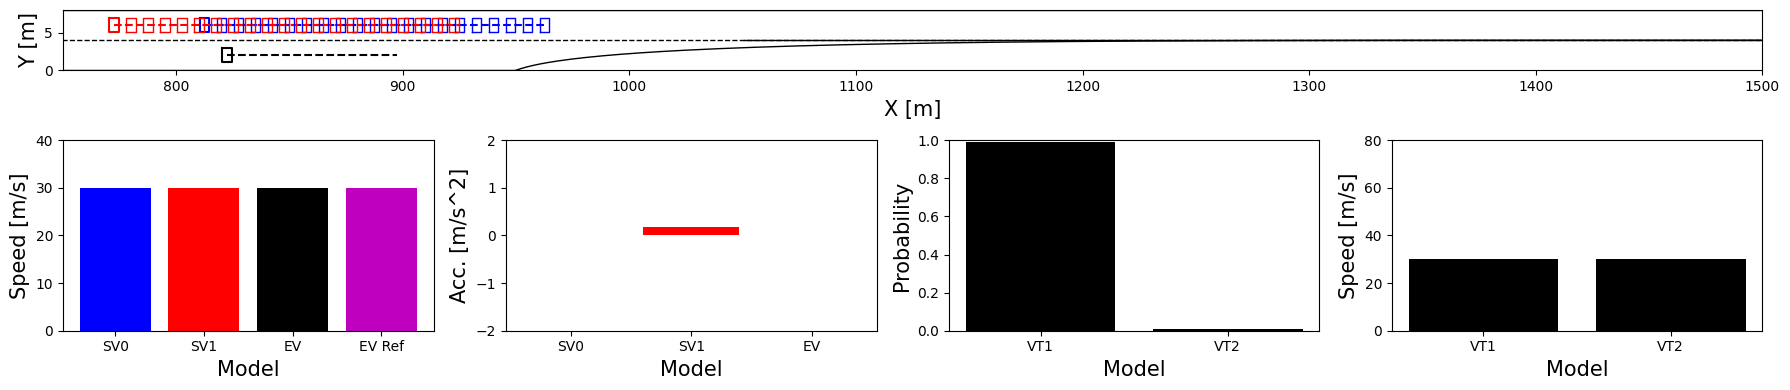

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(18, 4.0), tight_layout = True)
gs  = GridSpec(3, 4, figure=fig)
ax  = fig.add_subplot(gs[0, 0::], xlim=(x_min,  x_max), ylim=(0, L_Bound[-1] - L_Bound[0]))
ax_pro_0 = fig.add_subplot(gs[1::, 0],   ylim=(0, 40))
ax_pro_1 = fig.add_subplot(gs[1::, 1],   ylim=(-2, 2))
ax_pro_2 = fig.add_subplot(gs[1::, 2],   ylim=(0, 1))
ax_pro_3 = fig.add_subplot(gs[1::, 3],   ylim=(0, 80))
ax.set_xlabel('X [m]', fontsize=15)
ax.set_ylabel('Y [m]', fontsize=15)
ax_pro_0.set_xlabel('Model', fontsize=15)
ax_pro_0.set_ylabel('Speed [m/s]', fontsize=15)
ax_pro_1.set_xlabel('Model', fontsize=15)
ax_pro_1.set_ylabel('Acc. [m/s^2]', fontsize=15)
ax_pro_2.set_xlabel('Model', fontsize=15)
ax_pro_2.set_ylabel('Probability', fontsize=15)
ax_pro_3.set_xlabel('Model', fontsize=15)
ax_pro_3.set_ylabel('Speed [m/s]', fontsize=15)

speed      = ax_pro_0.bar(('SV0', 'SV1', 'EV', 'EV Ref'), [0, 0, 0, 0], color = ['b', 'r', 'k', 'm'])
acc        = ax_pro_1.bar(('SV0', 'SV1', 'EV'), [0, 0, 0], color = color_car)
prob       = ax_pro_2.bar(('VT1', 'VT2'), [0, 0], color = color_car[2])
speed_mode = ax_pro_3.bar(('VT1', 'VT2'), [0, 0], color = color_car[2])
             
state  = tuple([ax.plot(np.nan, np.nan, color_car[k], linewidth=1.5)[0] for k in range(N_Car)])
trajec = tuple([ax.plot(np.nan, np.nan, color_tra[k], linewidth=1.5)[0] for k in range(N_Car)])

Robust_SV_Horizon_0 = tuple([ax.plot(np.nan, np.nan, 'b', linewidth=1)[0] for k in range(N)])
Robust_SV_Horizon_1 = tuple([ax.plot(np.nan, np.nan, 'r', linewidth=1)[0] for k in range(N)])

def animate(i):
    
    for idx, statei in enumerate(state):
        if idx == 0: # SV
            x = State_SV0[0, i]
            y = State_SV0[2, i]
            box = [(x - l_veh/2, y + w_veh/2), (x + l_veh/2, y + w_veh/2), (x + l_veh/2, y - w_veh/2), (x - l_veh/2, y - w_veh/2)]
            heading = 0
            x_state, y_state = rota_rect(box, heading, x, y)
        elif idx == 1: # SV1
            x = State_SV1[0, i]
            y = State_SV1[2, i]
            box = [(x - l_veh/2, y + w_veh/2), (x + l_veh/2, y + w_veh/2), (x + l_veh/2, y - w_veh/2), (x - l_veh/2, y - w_veh/2)]
            heading = 0
            x_state, y_state = rota_rect(box, heading, x, y)
        else:
            x = State_EV_D[0, i]
            y = State_EV_D[1, i]
            box = [(x - l_veh/2, y + w_veh/2), (x + l_veh/2, y + w_veh/2), (x + l_veh/2, y - w_veh/2), (x - l_veh/2, y - w_veh/2)]
            heading = State_EV_D[2, i]
            x_state, y_state = rota_rect(box, heading, x, y)
        statei.set_xdata(x_state)
        statei.set_ydata(y_state)
        
    for idx, trajeci in enumerate(trajec):
        if idx <= 1: # SV0 and SV1
            x_planning = X_SV_Planning[i][idx][0]
            y_planning = Y_SV_Planning[i][idx]
        else:
            x_planning = X_EV_Planning_D[i][0]
            y_planning = X_EV_Planning_D[i][1]
        trajeci.set_xdata(x_planning)
        trajeci.set_ydata(y_planning)
    
    for idx, Robust_SV_i in enumerate(Robust_SV_Horizon_0):
            x_robust, y_robust = Robust_SV_Vertex(Robust_SV_D[i][0][:, idx], l_veh, w_veh)
            Robust_SV_i.set_xdata(x_robust)
            Robust_SV_i.set_ydata(y_robust)
    
    for idx, Robust_SV_i in enumerate(Robust_SV_Horizon_1):
            x_robust, y_robust = Robust_SV_Vertex(Robust_SV_D[i][1][:, idx], l_veh, w_veh)
            Robust_SV_i.set_xdata(x_robust)
            Robust_SV_i.set_ydata(y_robust)  

    for rect0 ,y0i in zip(speed, [State_SV0[1, i], State_SV1[1, i], State_EV_D[3, i], RefSpeed_EV_D[i]]):
        rect0.set_height(y0i)  
    
    for rect1 ,y1i in zip(acc, [Control_SV0[i], Control_SV1[i], State_EV_D[4, i]]):
        rect1.set_height(y1i)  
        
    for rect2, y2i in zip(prob, MU_EV_D[i]):
        rect2.set_height(y2i)
    
    for rect3, y3i in zip(speed_mode, REFSpeed_EV_All_D[i]):
        rect3.set_height(y3i)
    
        
    return state, trajec, Robust_SV_Horizon_0, Robust_SV_Horizon_1, speed, acc, prob, speed_mode

ax.plot(x_road, y_road, 'k', linewidth=1)
ax.plot(x, y, 'k', linewidth=1)
ax.plot(x_road, np.array([L_Bound[1]]*x_max), 'k--', linewidth=1)
ax.plot(x_road, np.array([L_Bound[2]]*x_max), 'k', linewidth=1)
            
ani = animation.FuncAnimation(fig, animate, frames = K_N, blit = False)
ani.save('Movie_D.mp4',writer='ffmpeg', fps=10)

## Animation for Proposed Approach

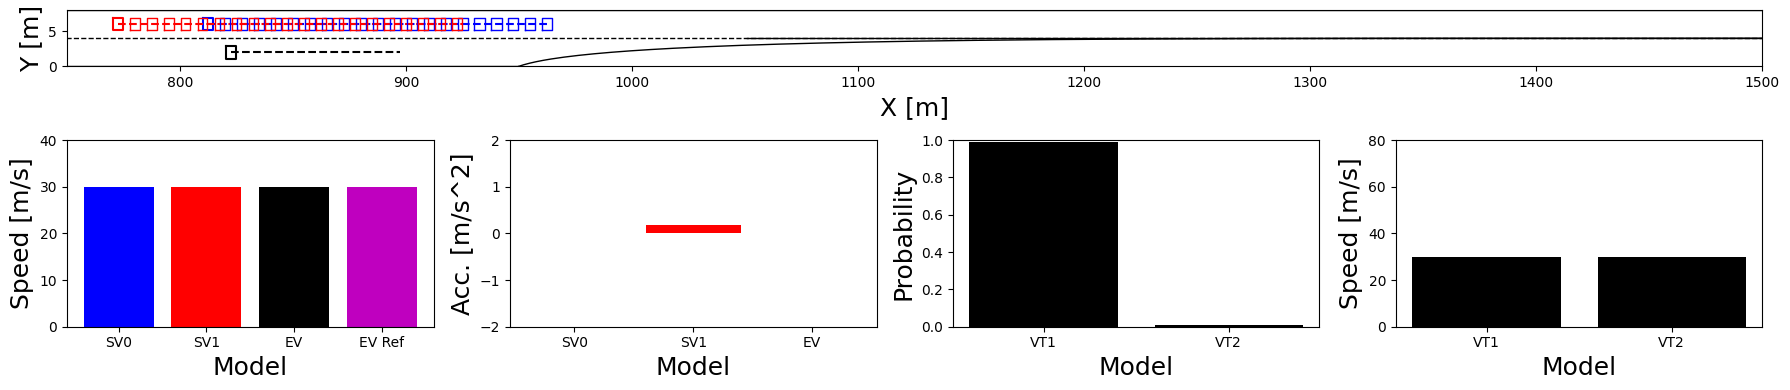

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(18, 4.0), tight_layout = True)
gs = GridSpec(3, 4, figure=fig)
ax = fig.add_subplot(gs[0, 0::], xlim=(x_min,  x_max), ylim=(0, L_Bound[-1] - L_Bound[0]))
ax_pro_0 = fig.add_subplot(gs[1::, 0],   ylim=(0, 40))
ax_pro_1 = fig.add_subplot(gs[1::, 1],   ylim=(-2, 2))
ax_pro_2 = fig.add_subplot(gs[1::, 2],   ylim=(0, 1))
ax_pro_3 = fig.add_subplot(gs[1::, 3],   ylim=(0, 80))
ax.set_xlabel('X [m]', fontsize=18)
ax.set_ylabel('Y [m]', fontsize=18)
ax_pro_0.set_xlabel('Model', fontsize=18)
ax_pro_0.set_ylabel('Speed [m/s]', fontsize=18)
ax_pro_1.set_xlabel('Model', fontsize=18)
ax_pro_1.set_ylabel('Acc. [m/s^2]', fontsize=18)
ax_pro_2.set_xlabel('Model', fontsize=18)
ax_pro_2.set_ylabel('Probability', fontsize=18)
ax_pro_3.set_xlabel('Model', fontsize=18)
ax_pro_3.set_ylabel('Speed [m/s]', fontsize=18)

speed      = ax_pro_0.bar(('SV0', 'SV1', 'EV', 'EV Ref'), [0, 0, 0, 0], color = ['b', 'r', 'k', 'm'])
acc        = ax_pro_1.bar(('SV0', 'SV1', 'EV'), [0, 0, 0], color = color_car)
prob       = ax_pro_2.bar(('VT1', 'VT2'), [0, 0], color = color_car[2])
speed_mode = ax_pro_3.bar(('VT1', 'VT2'), [0, 0], color = color_car[2])
                   
state = tuple([ax.plot(np.nan, np.nan, color_car[k],  linewidth =1.5)[0] for k in range(N_Car)])
trajec = tuple([ax.plot(np.nan, np.nan, color_tra[k], linewidth =1.5)[0] for k in range(N_Car)])

Robust_SV_Horizon_0 = tuple([ax.plot(np.nan, np.nan, 'b', linewidth=1)[0] for k in range(N)])
Robust_SV_Horizon_1 = tuple([ax.plot(np.nan, np.nan, 'r', linewidth=1)[0] for k in range(N)])

def animate(i):
    
    for idx, statei in enumerate(state):
        if idx == 0: # SV
            x = State_SV0[0, i]
            y = State_SV0[2, i]
            box = [(x - l_veh/2, y + w_veh/2), (x + l_veh/2, y + w_veh/2), (x + l_veh/2, y - w_veh/2), (x - l_veh/2, y - w_veh/2)]
            heading = 0
            x_state, y_state = rota_rect(box, heading, x, y)
        elif idx == 1: # SV1
            x = State_SV1[0, i]
            y = State_SV1[2, i]
            box = [(x - l_veh/2, y + w_veh/2), (x + l_veh/2, y + w_veh/2), (x + l_veh/2, y - w_veh/2), (x - l_veh/2, y - w_veh/2)]
            heading = 0
            x_state, y_state = rota_rect(box, heading, x, y)
        else:
            x = State_EV_P[0, i]
            y = State_EV_P[1, i]
            box = [(x - l_veh/2, y + w_veh/2), (x + l_veh/2, y + w_veh/2), (x + l_veh/2, y - w_veh/2), (x - l_veh/2, y - w_veh/2)]
            heading = State_EV_P[2, i]
            x_state, y_state = rota_rect(box, heading, x, y)
        statei.set_xdata(x_state)
        statei.set_ydata(y_state)
        
    for idx, trajeci in enumerate(trajec):
        if idx <= 1: # SV0 and SV1
            x_planning = X_SV_Planning[i][idx][0]
            y_planning = Y_SV_Planning[i][idx]
        else:
            x_planning = X_EV_Planning_P[i][0]
            y_planning = X_EV_Planning_P[i][1]
        trajeci.set_xdata(x_planning)
        trajeci.set_ydata(y_planning)
    
    for idx, Robust_SV_i in enumerate(Robust_SV_Horizon_0):
            x_robust, y_robust = Robust_SV_Vertex(Robust_SV_P[i][0][:, idx], l_veh, w_veh)
            Robust_SV_i.set_xdata(x_robust)
            Robust_SV_i.set_ydata(y_robust)
    
    for idx, Robust_SV_i in enumerate(Robust_SV_Horizon_1):
            x_robust, y_robust = Robust_SV_Vertex(Robust_SV_P[i][1][:, idx], l_veh, w_veh)
            Robust_SV_i.set_xdata(x_robust)
            Robust_SV_i.set_ydata(y_robust)  

    for rect0 ,y0i in zip(speed, [State_SV0[1, i], State_SV1[1, i], State_EV_P[3, i], RefSpeed_EV_P[i]]):
        rect0.set_height(y0i)  
    
    for rect1 ,y1i in zip(acc, [Control_SV0[i], Control_SV1[i], State_EV_P[4, i]]):
        rect1.set_height(y1i)  
        
    for rect2, y2i in zip(prob, MU_EV_P[i]):
        rect2.set_height(y2i)
    
    for rect3, y3i in zip(speed_mode, REFSpeed_EV_All_P[i]):
        rect3.set_height(y3i)

     
    return state, trajec, Robust_SV_Horizon_0, Robust_SV_Horizon_1, speed, acc, prob, speed_mode

ax.plot(x_road, y_road, 'k', linewidth=1)
ax.plot(x, y, 'k', linewidth=1)
ax.plot(x_road, np.array([L_Bound[1]]*x_max), 'k--', linewidth=1)
ax.plot(x_road, np.array([L_Bound[2]]*x_max), 'k', linewidth=1)
 
ani = animation.FuncAnimation(fig, animate, frames = K_N, blit = False)
ani.save('Movie_P.mp4',writer='ffmpeg', fps=10)

## Animation for Robust Approach

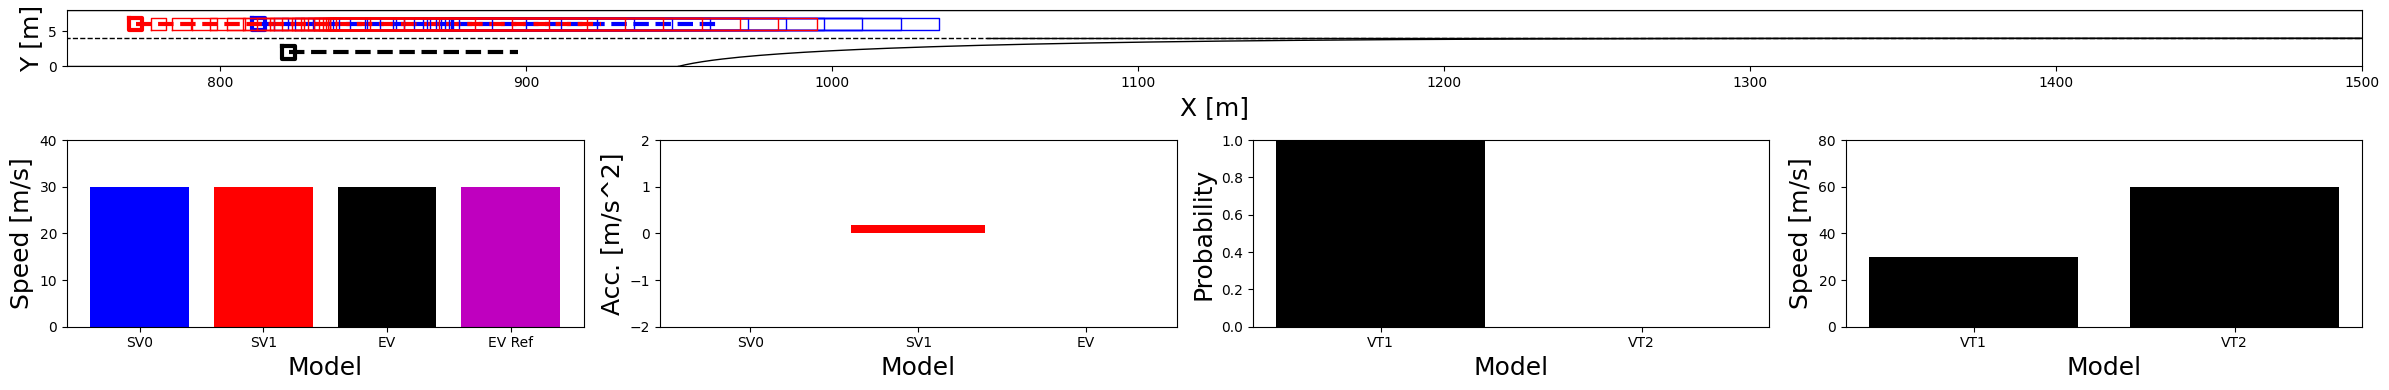

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(24, 4.0), tight_layout = True)
gs = GridSpec(3, 4, figure=fig)
ax = fig.add_subplot(gs[0, 0::], xlim=(x_min,  x_max), ylim=(0, L_Bound[-1] - L_Bound[0]))
ax_pro_0 = fig.add_subplot(gs[1::, 0],   ylim=(0, 40))
ax_pro_1 = fig.add_subplot(gs[1::, 1],   ylim=(-2, 2))
ax_pro_2 = fig.add_subplot(gs[1::, 2],   ylim=(0, 1))
ax_pro_3 = fig.add_subplot(gs[1::, 3],   ylim=(0, 80))
ax.set_xlabel('X [m]', fontsize=18)
ax.set_ylabel('Y [m]', fontsize=18)
ax_pro_0.set_xlabel('Model', fontsize=18)
ax_pro_0.set_ylabel('Speed [m/s]', fontsize=18)
ax_pro_1.set_xlabel('Model', fontsize=18)
ax_pro_1.set_ylabel('Acc. [m/s^2]', fontsize=18)
ax_pro_2.set_xlabel('Model', fontsize=18)
ax_pro_2.set_ylabel('Probability', fontsize=18)
ax_pro_3.set_xlabel('Model', fontsize=18)
ax_pro_3.set_ylabel('Speed [m/s]', fontsize=18)

speed  = ax_pro_0.bar(('SV0', 'SV1', 'EV', 'EV Ref'), [0, 0, 0, 0], color = ['b', 'r', 'k', 'm'])
acc      = ax_pro_1.bar(('SV0', 'SV1', 'EV'), [0, 0, 0], color = color_car)
prob    = ax_pro_2.bar(('VT1', 'VT2'), [0, 0], color = color_car[2])
speed_mode = ax_pro_3.bar(('VT1', 'VT2'), [0, 0], color = color_car[2])
                    
state = tuple([ax.plot(np.nan, np.nan, color_car[k], linewidth=3)[0] for k in range(N_Car)])
trajec = tuple([ax.plot(np.nan, np.nan, color_tra[k], linewidth=3)[0] for k in range(N_Car)])

Robust_SV_Horizon_0 = tuple([ax.plot(np.nan, np.nan, 'b', linewidth=1)[0] for k in range(N)])
Robust_SV_Horizon_1 = tuple([ax.plot(np.nan, np.nan, 'r', linewidth=1)[0] for k in range(N)])

def animate(i):
    
    for idx, statei in enumerate(state):
        if idx == 0: # SV
            x = State_SV0[0, i]
            y = State_SV0[2, i]
            box = [(x - l_veh/2, y + w_veh/2), (x + l_veh/2, y + w_veh/2), (x + l_veh/2, y - w_veh/2), (x - l_veh/2, y - w_veh/2)]
            heading = 0
            x_state, y_state = rota_rect(box, heading, x, y)
        elif idx == 1: # SV1
            x = State_SV1[0, i]
            y = State_SV1[2, i]
            box = [(x - l_veh/2, y + w_veh/2), (x + l_veh/2, y + w_veh/2), (x + l_veh/2, y - w_veh/2), (x - l_veh/2, y - w_veh/2)]
            heading = 0
            x_state, y_state = rota_rect(box, heading, x, y)
        else:
            x = State_EV_R[0, i]
            y = State_EV_R[1, i]
            box = [(x - l_veh/2, y + w_veh/2), (x + l_veh/2, y + w_veh/2), (x + l_veh/2, y - w_veh/2), (x - l_veh/2, y - w_veh/2)]
            heading = State_EV_R[2, i]
            x_state, y_state = rota_rect(box, heading, x, y)
        statei.set_xdata(x_state)
        statei.set_ydata(y_state)
        
    for idx, trajeci in enumerate(trajec):
        if idx <= 1: # SV0 and SV1
            x_planning = X_SV_Planning[i][idx][0]
            y_planning = Y_SV_Planning[i][idx]
        else:
            x_planning = X_EV_Planning_R[i][0]
            y_planning = X_EV_Planning_R[i][1]
        trajeci.set_xdata(x_planning)
        trajeci.set_ydata(y_planning)
    
    for idx, Robust_SV_i in enumerate(Robust_SV_Horizon_0):
            x_robust, y_robust = Robust_SV_Vertex(Robust_SV_R[i][0][:, idx], l_veh, w_veh)
            Robust_SV_i.set_xdata(x_robust)
            Robust_SV_i.set_ydata(y_robust)
    
    for idx, Robust_SV_i in enumerate(Robust_SV_Horizon_1):
            x_robust, y_robust = Robust_SV_Vertex(Robust_SV_R[i][1][:, idx], l_veh, w_veh)
            Robust_SV_i.set_xdata(x_robust)
            Robust_SV_i.set_ydata(y_robust)  

    for rect0 ,y0i in zip(speed, [State_SV0[1, i], State_SV1[1, i], State_EV_R[3, i], RefSpeed_EV_R[i]]):
        rect0.set_height(y0i)  
    
    for rect1 ,y1i in zip(acc, [Control_SV0[i], Control_SV1[i], State_EV_R[4, i]]):
        rect1.set_height(y1i)  
        
    for rect2, y2i in zip(prob, MU_EV_R[i]):
        rect2.set_height(y2i)
    
    for rect3, y3i in zip(speed_mode, REFSpeed_EV_All_R[i]):
        rect3.set_height(y3i)
    
     
    return state, trajec, Robust_SV_Horizon_0, Robust_SV_Horizon_1, speed, acc, prob, speed_mode

ax.plot(x_road, y_road, 'k', linewidth=1)
ax.plot(x, y, 'k', linewidth=1)
ax.plot(x_road, np.array([L_Bound[1]]*x_max), 'k--', linewidth=1)
ax.plot(x_road, np.array([L_Bound[2]]*x_max), 'k', linewidth=1)
       
ani = animation.FuncAnimation(fig, animate, frames = K_N, blit = False)
ani.save('Movie_R.mp4',writer='ffmpeg', fps=10)